In [2]:
import time
import json
import random
import numpy as np
from copy import deepcopy
from smol.io import load_work
from smol.cofe.space import Vacancy
from smol.moca.sampler.mcusher import Tableflip
from smol.moca import Ensemble
from smol.moca import Sampler
from pymatgen.core.sites import Species
from pymatgen.core.structure import Structure
from pymatgen.transformations.standard_transformations \
import (OxidationStateDecorationTransformation, \
        OrderDisorderedStructureTransformation)
from monty.serialization import dumpfn, loadfn

/Users/yun/opt/anaconda3/envs/cn-sgmc/lib/python3.9/site-packages/pymatgen/analysis/phase_diagram.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. Load data from cluster expansion fitting & Generate Ensemble
Note: For the details of fitting, refer to groupCE_CaNaVP

In [3]:
work = load_work('/global/scratch/users/yychoi94/CaNaVP/data/final_data/ce/final_canvp_ce.mson')
expansion = work['ClusterExpansion']
wrangler = work['StructureWrangler']
print("{} Non-zero ECIS over {} cluster ECIS".format(np.count_nonzero(expansion.coefs), len(expansion.coefs)))

103 Non-zero ECIS over 629 cluster ECIS


### Set Basic variables. 

In [4]:
# Atoms.
na = Species('Na', 1)
ca = Species('Ca', 2)
v3 = Species('V', 3)
v4 = Species('V', 4)
v5 = Species('V', 5)
vac = Vacancy()

### Generate Basic Ensemble

In [5]:
# Create the ensemble
# This specifies the size of the MC simulation domain.
sc_matrix = np.array([[5, 0, 0],
                      [0, 5, 0],
                      [0, 0, 6]])

# relative chemical potentials are provided as a dict
chemical_potentials = {'Na+':0, 'Ca2+': 0, 'Vacancy': 0,
                       'V3+': 0, 'V4+': 0, 'V5+': 0}

# this convenience method will take care of creating the appropriate
# processor for the given cluster expansion.
ensemble = Ensemble.from_cluster_expansion(expansion,
                                           sc_matrix,
                                           chemical_potentials=chemical_potentials)

print(f'The supercell size for the processor is {ensemble.processor.size} prims.\n')
print(f'The ensemble has a total of {ensemble.num_sites} sites.\n')
for i in ensemble.sublattices:
    if na in i.species:
        print(f"The supercell has {len(i.active_sites)} cation sites.")
    elif v3 in i.species:
        print(f"The supercell has {len(i.active_sites)} transition metal sites.")

The supercell size for the processor is 150 prims.

The ensemble has a total of 6300 sites.

The supercell has 1200 cation sites.
The supercell has 600 transition metal sites.


## 2. Initializing sampler 
When initializring sampler from basic ensemble object, it calculate all the ewalds terms and will take a long time. Save ensemble has a precalculated data and will reduce time.

In [6]:
ensemble_path = '/global/home/users/yychoi94/notebooks/final_canvp_ensemble_1201.mson'
ensemble = loadfn(ensemble_path)
# dumpfn(ensemble, ensemble_path)

In [7]:
for sublattice in ensemble.sublattices:
    print(sublattice.species)

(Species O2-,)
(Species Na+, Species Ca2+, Vacancy vacA0+)
(Species V3+, Species V4+, Species V5+)
(Species P5+,)


In [8]:
# Specific flip table based on saved ensemble.
# Note that every ensemble have different order of sublattices, so need to do sanity check.
flip_table = np.array([[0,  -1,  0,  1,  -1,  1,  0,  0],
                       [0,  -1,  0,  1,  0,  -1,  1,  0],
                       [0,  0,  -1,  1,  -1,  0,  1,  0],
                       [0,  -2,  1,  1,  0,  0,  0,  0]])

In [9]:
start = time.time()
sampler = Sampler.from_ensemble(ensemble, step_type="tableflip",
                                temperature=2000, optimize_basis=False, flip_table=flip_table)

print(f"Sampling information: {sampler.samples.metadata}")
end = time.time()
print(f"{end-start}s for initialization.")

/global/home/users/yychoi94/miniconda3/envs/cn-sgmc/lib/python3.9/site-packages/smol/moca/sampler/mcusher.py:358: UserWarning: Current occupancy violates compspace constraints! Are you initializing trace?
  warnings.warn("Current occupancy violates compspace constraints! "


Sampling information: {'kernel': 'Metropolis', 'step': 'tableflip', 'chemical_potentials': {Species Na+: 0, Species Ca2+: 0, Vacancy vacA0+: 0, Species V3+: 0, Species V4+: 0, Species V5+: 0}, 'seeds': [187011463514356734272339672434314630841]}
0.7886078357696533s for initialization.


### Sanity Check

In [10]:
def get_dim_ids_by_sublattice(bits):
    """Get the component index of each species in vector n.

    Args:
        bits(List[List[Specie|Vacancy|Element]]):
           Species on each sub-lattice.
    Returns:
        Component index of each species on each sublattice in vector n:
           List[List[int]]
    """
    dim_ids = []
    dim_id = 0
    for species in bits:
        dim_ids.append(list(range(dim_id, dim_id + len(species))))
        dim_id += len(species)
    return dim_ids

def flip_vec_to_reaction(u, bits):
    """Convert flip direction into a reaction formula in string.

    This function is for easy interpretation of flip directions.
    Args:
        u(1D ArrayLike[int]):
            The flip vector in number change of species.
        bits(List[List[Specie|DummySpecie|Element|Vacancy]]):
            Species on all sub-lattices.
    Return:
        Reaction formulas: str.
    """
    u = np.array(u, dtype=int)
    dim_ids = get_dim_ids_by_sublattice(bits)

    from_strs = []
    to_strs = []

    for sl_id, (sl_species, sl_dims) in enumerate(zip(bits, dim_ids)):
        for specie, dim in zip(sl_species, sl_dims):
            if u[dim] < 0:
                from_strs.append('{} {}({})'
                                 .format(-u[dim], str(specie), sl_id))
            elif u[dim] > 0:
                to_strs.append('{} {}({})'
                               .format(u[dim], str(specie), sl_id))

    from_str = ' + '.join(from_strs)
    to_str = ' + '.join(to_strs)
    return from_str + ' -> ' + to_str

In [11]:
# The order of sublattices in sampler kernel.
compspace_bits = sampler.mckernels[0].mcusher._compspace.bits
bits = sampler.mckernels[0].mcusher.bits
assert compspace_bits == bits
print(bits)

[(Species O2-,), (Species Na+, Species Ca2+, Vacancy vacA0+), (Species V3+, Species V4+, Species V5+), (Species P5+,)]


In [12]:
# Specified flip table.
specified_flip_table = sampler.mckernels[0].mcusher.flip_table
assert specified_flip_table.all() == flip_table.all()
print(specified_flip_table)

[[ 0 -1  0  1 -1  1  0  0]
 [ 0 -1  0  1  0 -1  1  0]
 [ 0  0 -1  1 -1  0  1  0]
 [ 0 -2  1  1  0  0  0  0]]


In [13]:
# The base flip table.
original_flip_table = sampler.mckernels[0].mcusher._compspace.flip_table
print(original_flip_table)

[[ 0  1 -1  0 -1  1  0  0]
 [ 0  2 -2  0 -1  0  1  0]
 [ 0 -2  1  1  0  0  0  0]]


In [14]:
# Change specific filp table to readable reactions.
[flip_vec_to_reaction(u, bits) for u in original_flip_table]

['1 Ca2+(1) + 1 V3+(2) -> 1 Na+(1) + 1 V4+(2)',
 '2 Ca2+(1) + 1 V3+(2) -> 2 Na+(1) + 1 V5+(2)',
 '2 Na+(1) -> 1 Ca2+(1) + 1 vacA0+(1)']

In [15]:
# Change original filp table to readable reactions.
[flip_vec_to_reaction(u, bits) for u in specified_flip_table]

['1 Na+(1) + 1 V3+(2) -> 1 vacA0+(1) + 1 V4+(2)',
 '1 Na+(1) + 1 V4+(2) -> 1 vacA0+(1) + 1 V5+(2)',
 '1 Ca2+(1) + 1 V3+(2) -> 1 vacA0+(1) + 1 V5+(2)',
 '2 Na+(1) -> 1 Ca2+(1) + 1 vacA0+(1)']

In [16]:
# Check ushers
sampler.mckernels[0].valid_mcushers

['Flip', 'Swap', 'Tableflip']

In [17]:
# Check cheical potential variables
ensemble.thermo_boundaries

{'chemical_potentials': {Species Na+: 0,
  Species Ca2+: 0,
  Vacancy vacA0+: 0,
  Species V3+: 0,
  Species V4+: 0,
  Species V5+: 0}}

In [18]:
# Basis of column space in compositional space.
sampler.mckernels[0].mcusher._compspace.flip_reactions

['1 Ca2+(1) + 1 V3+(2) -> 1 Na+(1) + 1 V4+(2)',
 '2 Ca2+(1) + 1 V3+(2) -> 2 Na+(1) + 1 V5+(2)',
 '2 Na+(1) -> 1 Ca2+(1) + 1 vacA0+(1)']

## 3. Initializing Structure with random basis (Just for testing)

In [19]:
# Initializing structure.
from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation

# Here we will just use the order disordered transformation from
# pymatgen to get an ordered version of a prim supercell.
# The structure will have the same composition set in the prim.
transformation = OrderDisorderedStructureTransformation()

supercell = expansion.cluster_subspace.structure.copy()
supercell.make_supercell(sc_matrix)

# this can take a bit of time....
#test_struct = transformation.apply_transformation(supercell)
#print(test_struct.composition)

In [20]:
init_cat_occ = {na:1/3, ca:1/6, vac:1-1/3-1/6}

v_avg = 9/2 - init_cat_occ[ca] * 4 - init_cat_occ[na] * 4 / 2

if 3 < v_avg < 4:
    init_v_occ = {v3: 4 - v_avg, v4: v_avg - 3, v5: 0}
elif 4 < v_avg < 5:
    init_v_occ = {v3: 0, v4: 5 - v_avg, v5: v_avg - 4}
elif v_avg == 4:
    init_v_occ = {v3: 0, v4: 1, v5: 0}
elif v_avg == 3:
    init_v_occ = {v3: 1, v4: 0, v5: 0}

In [21]:
9/2 - 1/6 * 4 - 1/3 * 4 / 2

3.166666666666667

In [22]:
test_struct = deepcopy(supercell)

for sublatt in ensemble.active_sublattices:
    act_sites = sublatt.active_sites
    act_species = sublatt.species
    random.shuffle(act_sites)
    
    split = [0]
    mark = split[0]
    
    if na in act_species:
        for specie in act_species:
            mark += round(len(act_sites) * init_cat_occ[specie])
            split.append(mark)
    else:
        for specie in act_species:
            mark += round((len(act_sites) * init_v_occ[specie]))
            split.append(mark)
            
    for num, specie in enumerate(act_species):
        for i, j in enumerate(act_sites):
            if i < split[num + 1] and i >= split[num]:
                test_struct[int(j)] = specie
    
    print(split)

[0, 400, 600, 1200]
[0, 500, 600, 600]


In [23]:
sites2remove = []
for i, site in enumerate(test_struct):
    if site.species_string == 'vacA0+':
        sites2remove.append(i)
test_struct.remove_sites(sites2remove)

In [24]:
struct_address = "/global/scratch/users/yychoi94/CaNaVP/gcmc_script/POSCAR"

In [ ]:
# Obtain the initial occupancy string from the
# test structure created above.
init_occu = ensemble.processor.occupancy_from_structure(test_struct)

# The occupancy strings created by the processor
# are by default "encoded" by the indices of the species
# for each given site. You can always see the actual
# species in the occupancy string by decoding it.
print(f'The encoded occupancy is:\n{init_occu}')
print(f'The initial occupancy is:\n {ensemble.processor.decode_occupancy(init_occu)}')

In [26]:
tot_chg = 0

In [27]:
for i in test_struct:
    if i.species_string == 'Na+':
        tot_chg += 1
    elif i.species_string == 'Ca2+':
        tot_chg += 2
    elif i.species_string == 'O2-':
        tot_chg -= 2
    elif i.species_string == 'P5+':
        tot_chg += 5
    elif i.species_string == 'V3+':
        tot_chg += 3
    elif i.species_string == 'V4+':
        tot_chg += 4
    elif i.species_string == 'V5+':
        tot_chg += 5

In [28]:
tot_chg

0

## 4. Test MC

In [29]:
from matplotlib import pyplot as plt

ca_dmu = -8
na_dmu = -6.5
chemical_potentials['Na+'] = na_dmu
chemical_potentials['Ca2+'] = ca_dmu
discard, thin_by = 50, 10
ensemble.chemical_potentials = chemical_potentials

In [30]:
init_occu = np.load('/global/scratch/users/yychoi94/CaNaVP/notebooks/5000_8.5_4.5_occu.npy')

In [31]:
len(init_occu)

6300

In [33]:
sampler.run(nsteps=50000,
            initial_occupancies=init_occu,
            thin_by=10,
            progress=True)

Sampling 1 chain(s) from a cell with 6300 sites...: 100%|██████████| 50000/50000 [01:23<00:00, 595.84it/s]


In [34]:
sampler.mckernels[0].seed

187011463514356734272339672434314630841

In [35]:
sampler.clear_samples()

In [36]:
sampler.run(50000, init_occu, thin_by=thin_by, progress=True)

Sampling 1 chain(s) from a cell with 6300 sites...: 100%|██████████| 50000/50000 [01:24<00:00, 592.16it/s]


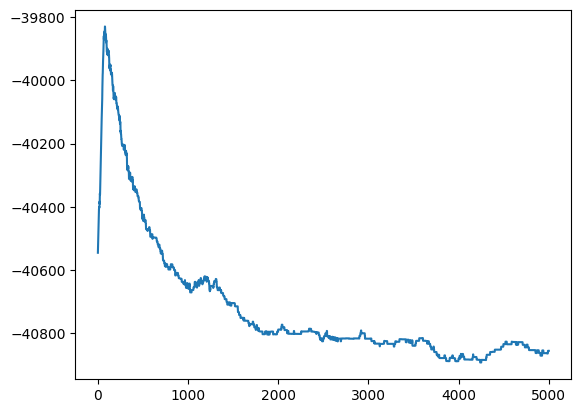

In [37]:
plt.plot(sampler.samples.get_energies())

In [38]:
sampler.mckernels[0].mcusher.flip_table

array([[ 0, -1,  0,  1, -1,  1,  0,  0],
       [ 0, -1,  0,  1,  0, -1,  1,  0],
       [ 0,  0, -1,  1, -1,  0,  1,  0],
       [ 0, -2,  1,  1,  0,  0,  0,  0]])

In [39]:
sampler.mckernels[0].mcusher._compspace.flip_reactions

['1 Ca2+(1) + 1 V3+(2) -> 1 Na+(1) + 1 V4+(2)',
 '2 Ca2+(1) + 1 V3+(2) -> 2 Na+(1) + 1 V5+(2)',
 '2 Na+(1) -> 1 Ca2+(1) + 1 vacA0+(1)']

In [34]:
sampler.samples.metadata['flip_reactions'] = sampler.mckernels[0].mcusher._compspace.flip_reactions

In [35]:
sampler.samples.metadata

{'kernel': 'Metropolis',
 'step': 'tableflip',
 'chemical_potentials': {Species Na+: -6.5,
  Species Ca2+: -8,
  Vacancy vacA0+: 0,
  Species V3+: 0,
  Species V4+: 0,
  Species V5+: 0},
 'seeds': [21180213679242342513328138463334693071],
 'flip_reactions': ['1 Na+(1) + 1 V3+(2) -> 1 vacA0+(1) + 1 V4+(2)',
  '2 Na+(1) -> 1 Ca2+(1) + 1 vacA0+(1)',
  '1 Ca2+(1) + 1 V3+(2) -> 1 vacA0+(1) + 1 V5+(2)']}

In [26]:
test_path = './test_samples'

In [27]:
dumpfn(sampler.samples, test_path)

### Retrieve & Test trajectory from preliminary sampled data.
#### Need to make into class
#### Need to build convergence check
#### Need to build trajectory checker

In [3]:
from smol.moca.sampler.container import SampleContainer
from matplotlib import pyplot as plt
from glob import glob

In [4]:
# Finished functions

def read_json(fjson):
    with open(fjson) as f:
        return json.load(f)


def write_json(d, fjson):
    with open(fjson, 'w') as f:
        json.dump(d, f)
    return d

def get_data_from_hdf5(saved_path):
    
    return

def get_data_from_nps(saved_path):
    
    return

def get_discard_length():
    
    # Need low temperature run data to test
    
    return

def get_sampling_efficiency(energies, discard_length, sampling_length):
    """
    Args:
        energies: NumPy array. Sampled energy.
        discard_length: Int. Equilibrium length of the sample.
        sampling_length: Int. Sampling length to get sampling efficiency.
    Returns:
        tot_var: total variance of the entire sample.
        block_var: block variance.
        sampling_efficiency: Idealy 1.
    """
    blocks = []
    block_means = []
    start_position = discard_length
    tot_var = np.var(energies[discard_length:])

    while start_position + sampling_length < len(energies):
        blocks.append(energies[start_position : start_position + sampling_length])
        start_position += sampling_length

    for i in blocks:
        block_means.append(i.mean())
    block_var = np.var(block_means)
    sampling_efficiency = tot_var / sampling_length / block_var
    
    return tot_var, block_var, sampling_efficiency

def get_thin_trajectory(species_count, discard_length, thin_by):
    """
    Args:
        species_count: Dict. of counted number of species
        discard_length: Int. Equilibrium length of the sample.
        thin_by: Int. Thin by number.
    Returns:
        thin_trajectory: List of tuple (Ca2+, Na+). Thinned tracjectory
        average: Average value of ensemble.
    """
    # Assume that sampled from 5x5x6 size ensemble
    thin_trajectory = []
    discarded_na = species_count['Na+'][discard_length:]
    discarded_ca = species_count['Ca2+'][discard_length:]
    ca_total = 0
    na_total = 0
    count = 0
    for i, j in enumerate(discarded_na):
        if i % thin_by == 0:
            thin_trajectory.append((discarded_ca[i]/300, j/300))
        count += 1
        ca_total += discarded_ca[i]/300
        na_total += j/300
    ca_average = ca_total / count
    na_average = na_total / count
    
    return thin_trajectory, (ca_average, na_average)

def get_all_trajectories(saved_dir, discard_length, thin_by):
    
    traj_data = {}
    species_count_list = []
    saved_list = glob(saved_dir + "/*")
    for i in saved_list:
        if "species_count" in i:
            species_count_list.append(i)
    for j in species_count_list:
        spec_species_count = read_json(j)
        spec_species_count = json.loads(spec_species_count)
        thin_trajectory, average = get_thin_trajectory(spec_species_count, discard_length, thin_by)
        # Need to automate key generation
        key = '_'.join(j.split("/")[-1].split("_")[:2])
        traj_data[key] = {}
        traj_data[key]['trajectory'] = thin_trajectory
        traj_data[key]['average'] = average
    
    return traj_data

In [29]:
save_dir = "/global/scratch/users/yychoi94/CaNaVP_gcMC/300K_556_30_6020/data"
saved_list = glob(save_dir + "/*")
tot_cation_site = round(np.linalg.det(ensemble.processor.supercell_matrix)) * 8

In [30]:
test_traj_data = get_all_trajectories(save_dir, 50000, 5000)

In [ ]:
write_json(test_traj_data, './300K_Na_only_traj.json')

In [54]:
test_traj_data = read_json('/Users/yun/Berkeley/Codes/CaNaVP/data/traj_Ca_lowU300K.json')

In [55]:
chempos = []
nas = []
for key in test_traj_data:
    chempo = float(key.split('_')[0])
    voltage = (-1.9985 - chempo)/2
    chempos.append(voltage)
    nas.append(test_traj_data[key]['average'][0])

In [45]:
chempos = []
nas = []
for key in test_traj_data:
    chempo = float(key.split('_')[-1])
    voltage = (-1.3122 - chempo)
    chempos.append(voltage)
    nas.append(test_traj_data[key]['average'][1])

In [46]:
sorted_chempos = [x for _, x in sorted(zip(nas, chempos))]

In [47]:
nas.sort()

In [51]:
sorted_chempos = np.array(sorted_chempos) + 0.2

(0.25, 3.25)

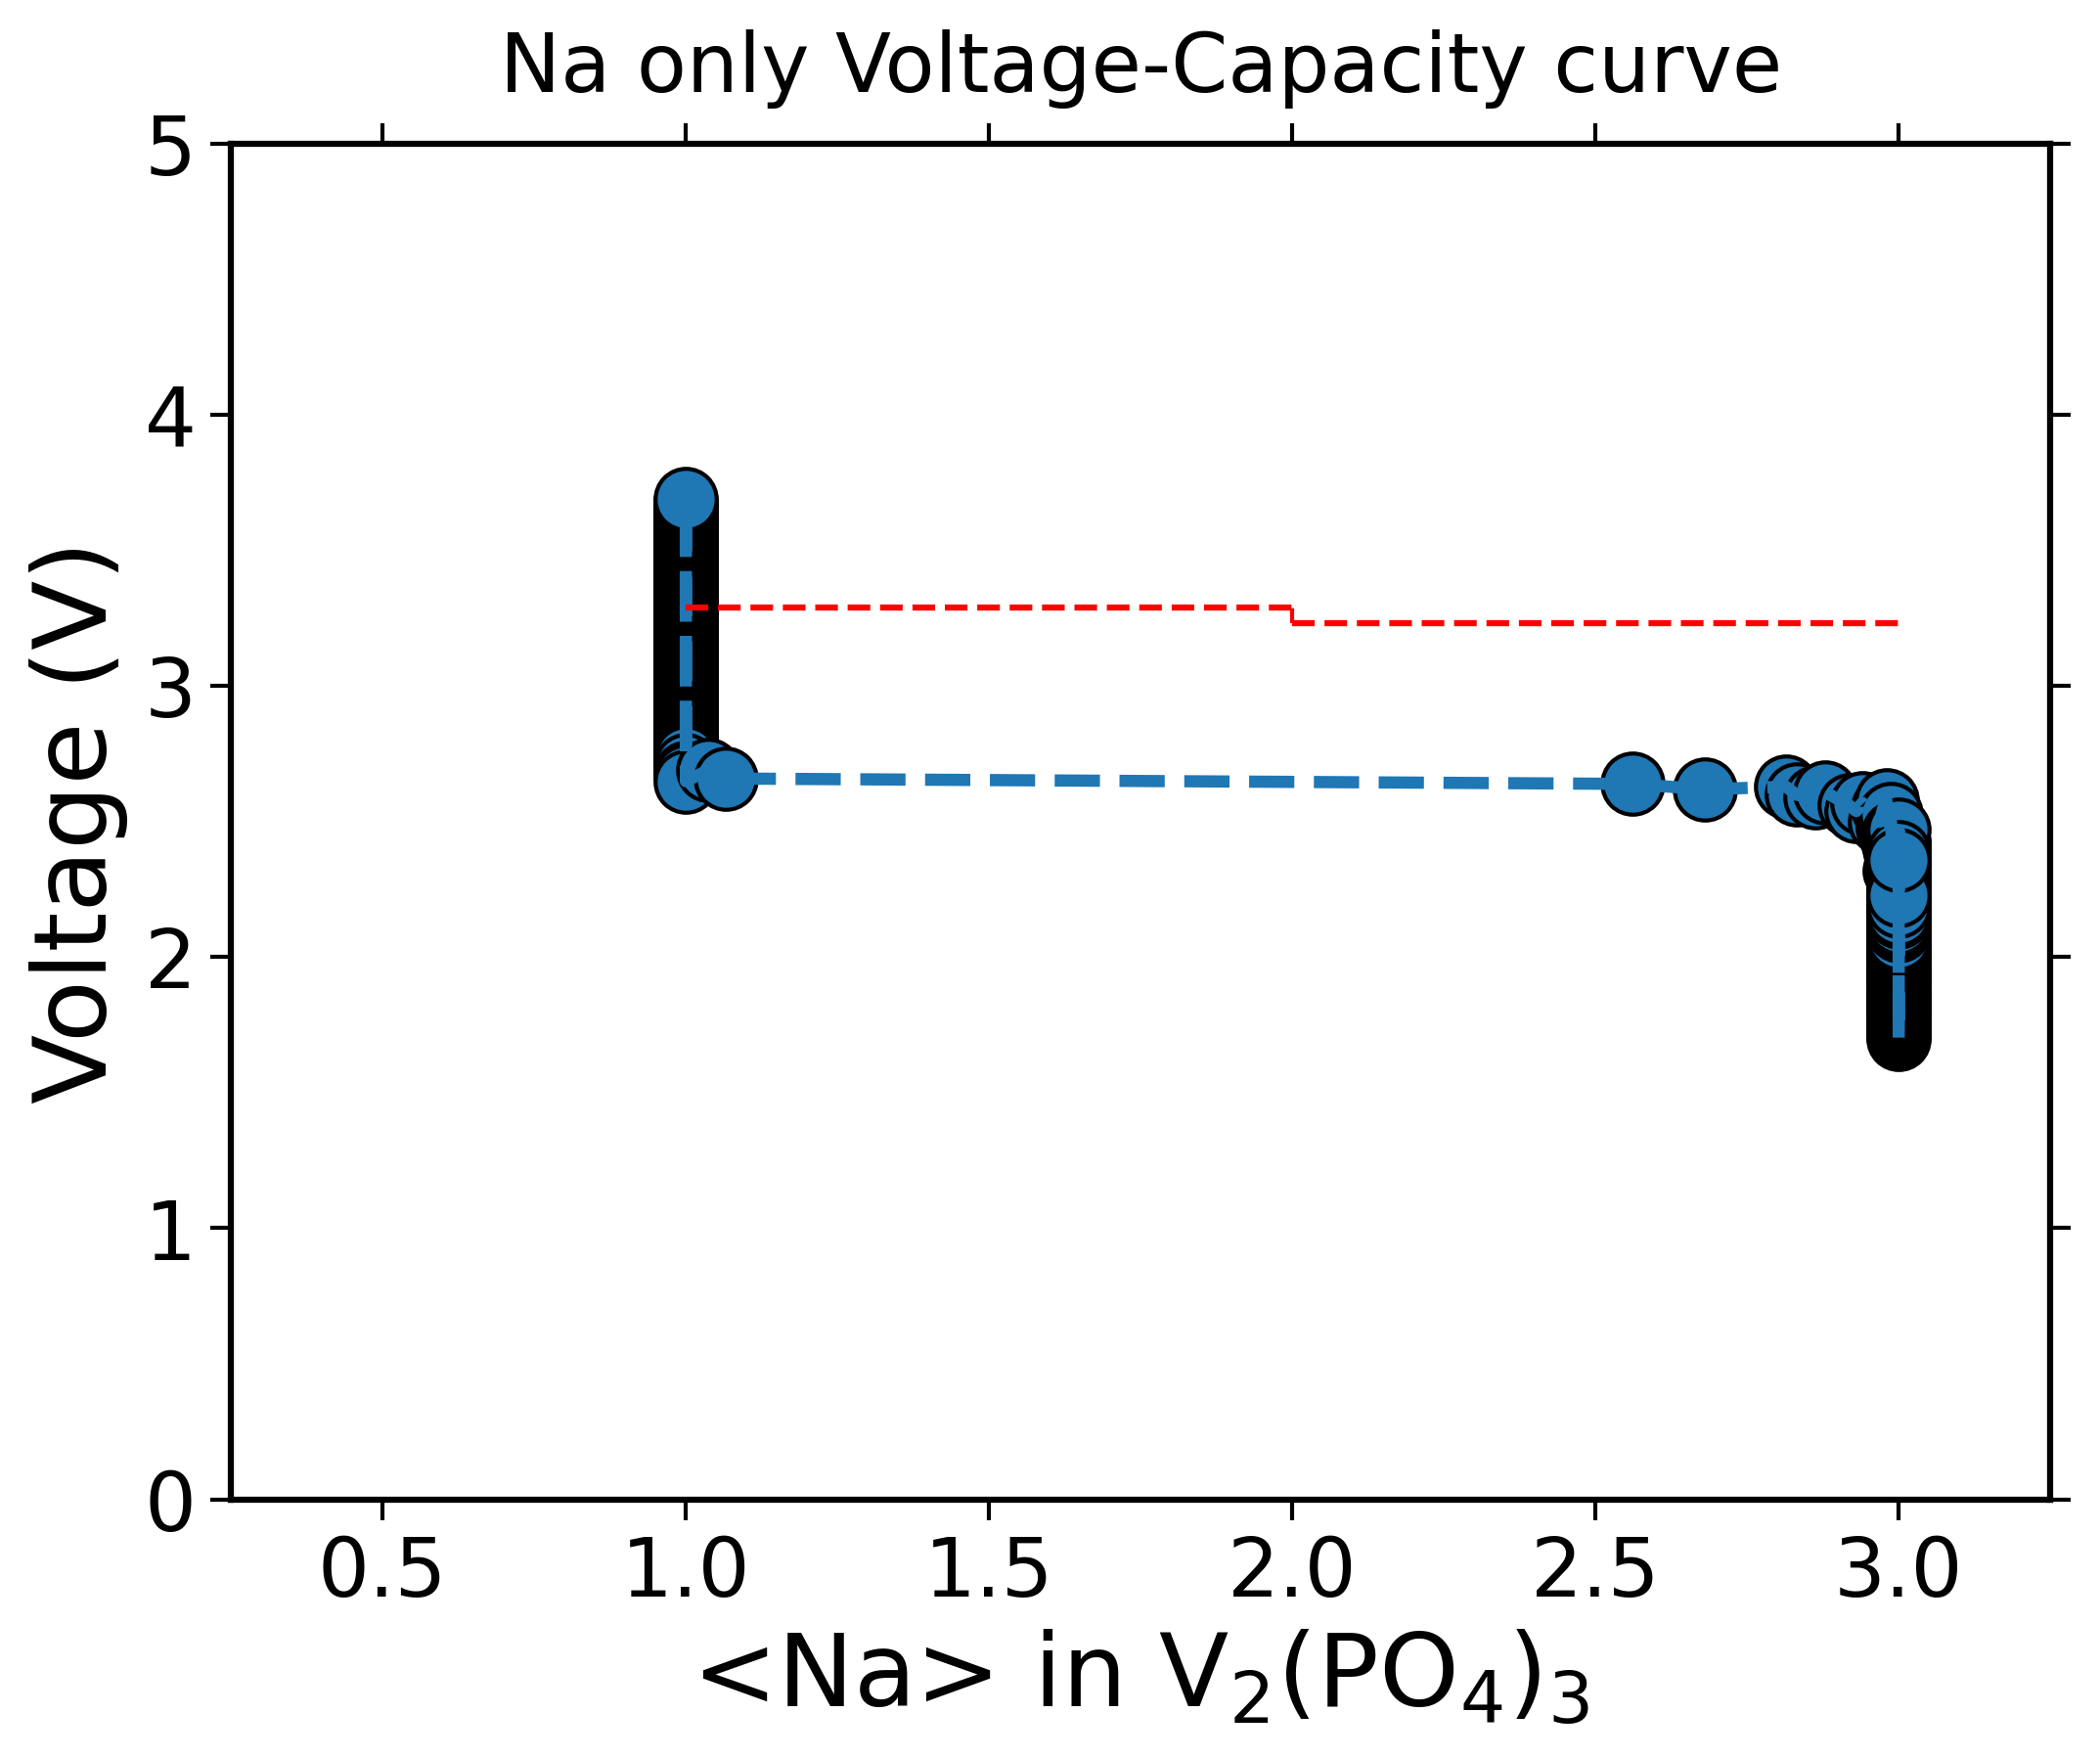

In [52]:
plt.scatter(nas, sorted_chempos, color='tab:blue', edgecolors='black', linewidth=1)
plt.plot(nas, sorted_chempos, linestyle='--', color='tab:blue')
plt.axhline(3.29, xmin=0.75/3, xmax=1.75/3, linestyle='--',linewidth=1.5, color='r')
plt.axhline(3.23, xmin=1.75/3, xmax=2.75/3, linestyle='--',linewidth=1.5, color='r')
plt.axvline(2, ymin=3.23/5, ymax=3.29/5, linestyle='--',linewidth=1, color='r')
plt.title("Na only Voltage-Capacity curve", fontsize=20, y=1.02)
plt.xlabel("<Na> in $V_{2}(PO_{4})_{3}$")
plt.ylabel("Voltage (V)")
plt.ylim(0, 5)
plt.xlim(0.25, 3.25)

In [56]:
sorted_chempos = [x for _, x in sorted(zip(nas, chempos))]

In [60]:
re = []
for i in nas:
    if i > 0.5:
        re.append(i * 1.5/1.333)
    else:
        re.append(i)

In [57]:
nas.sort()

(-0.25, 1.75)

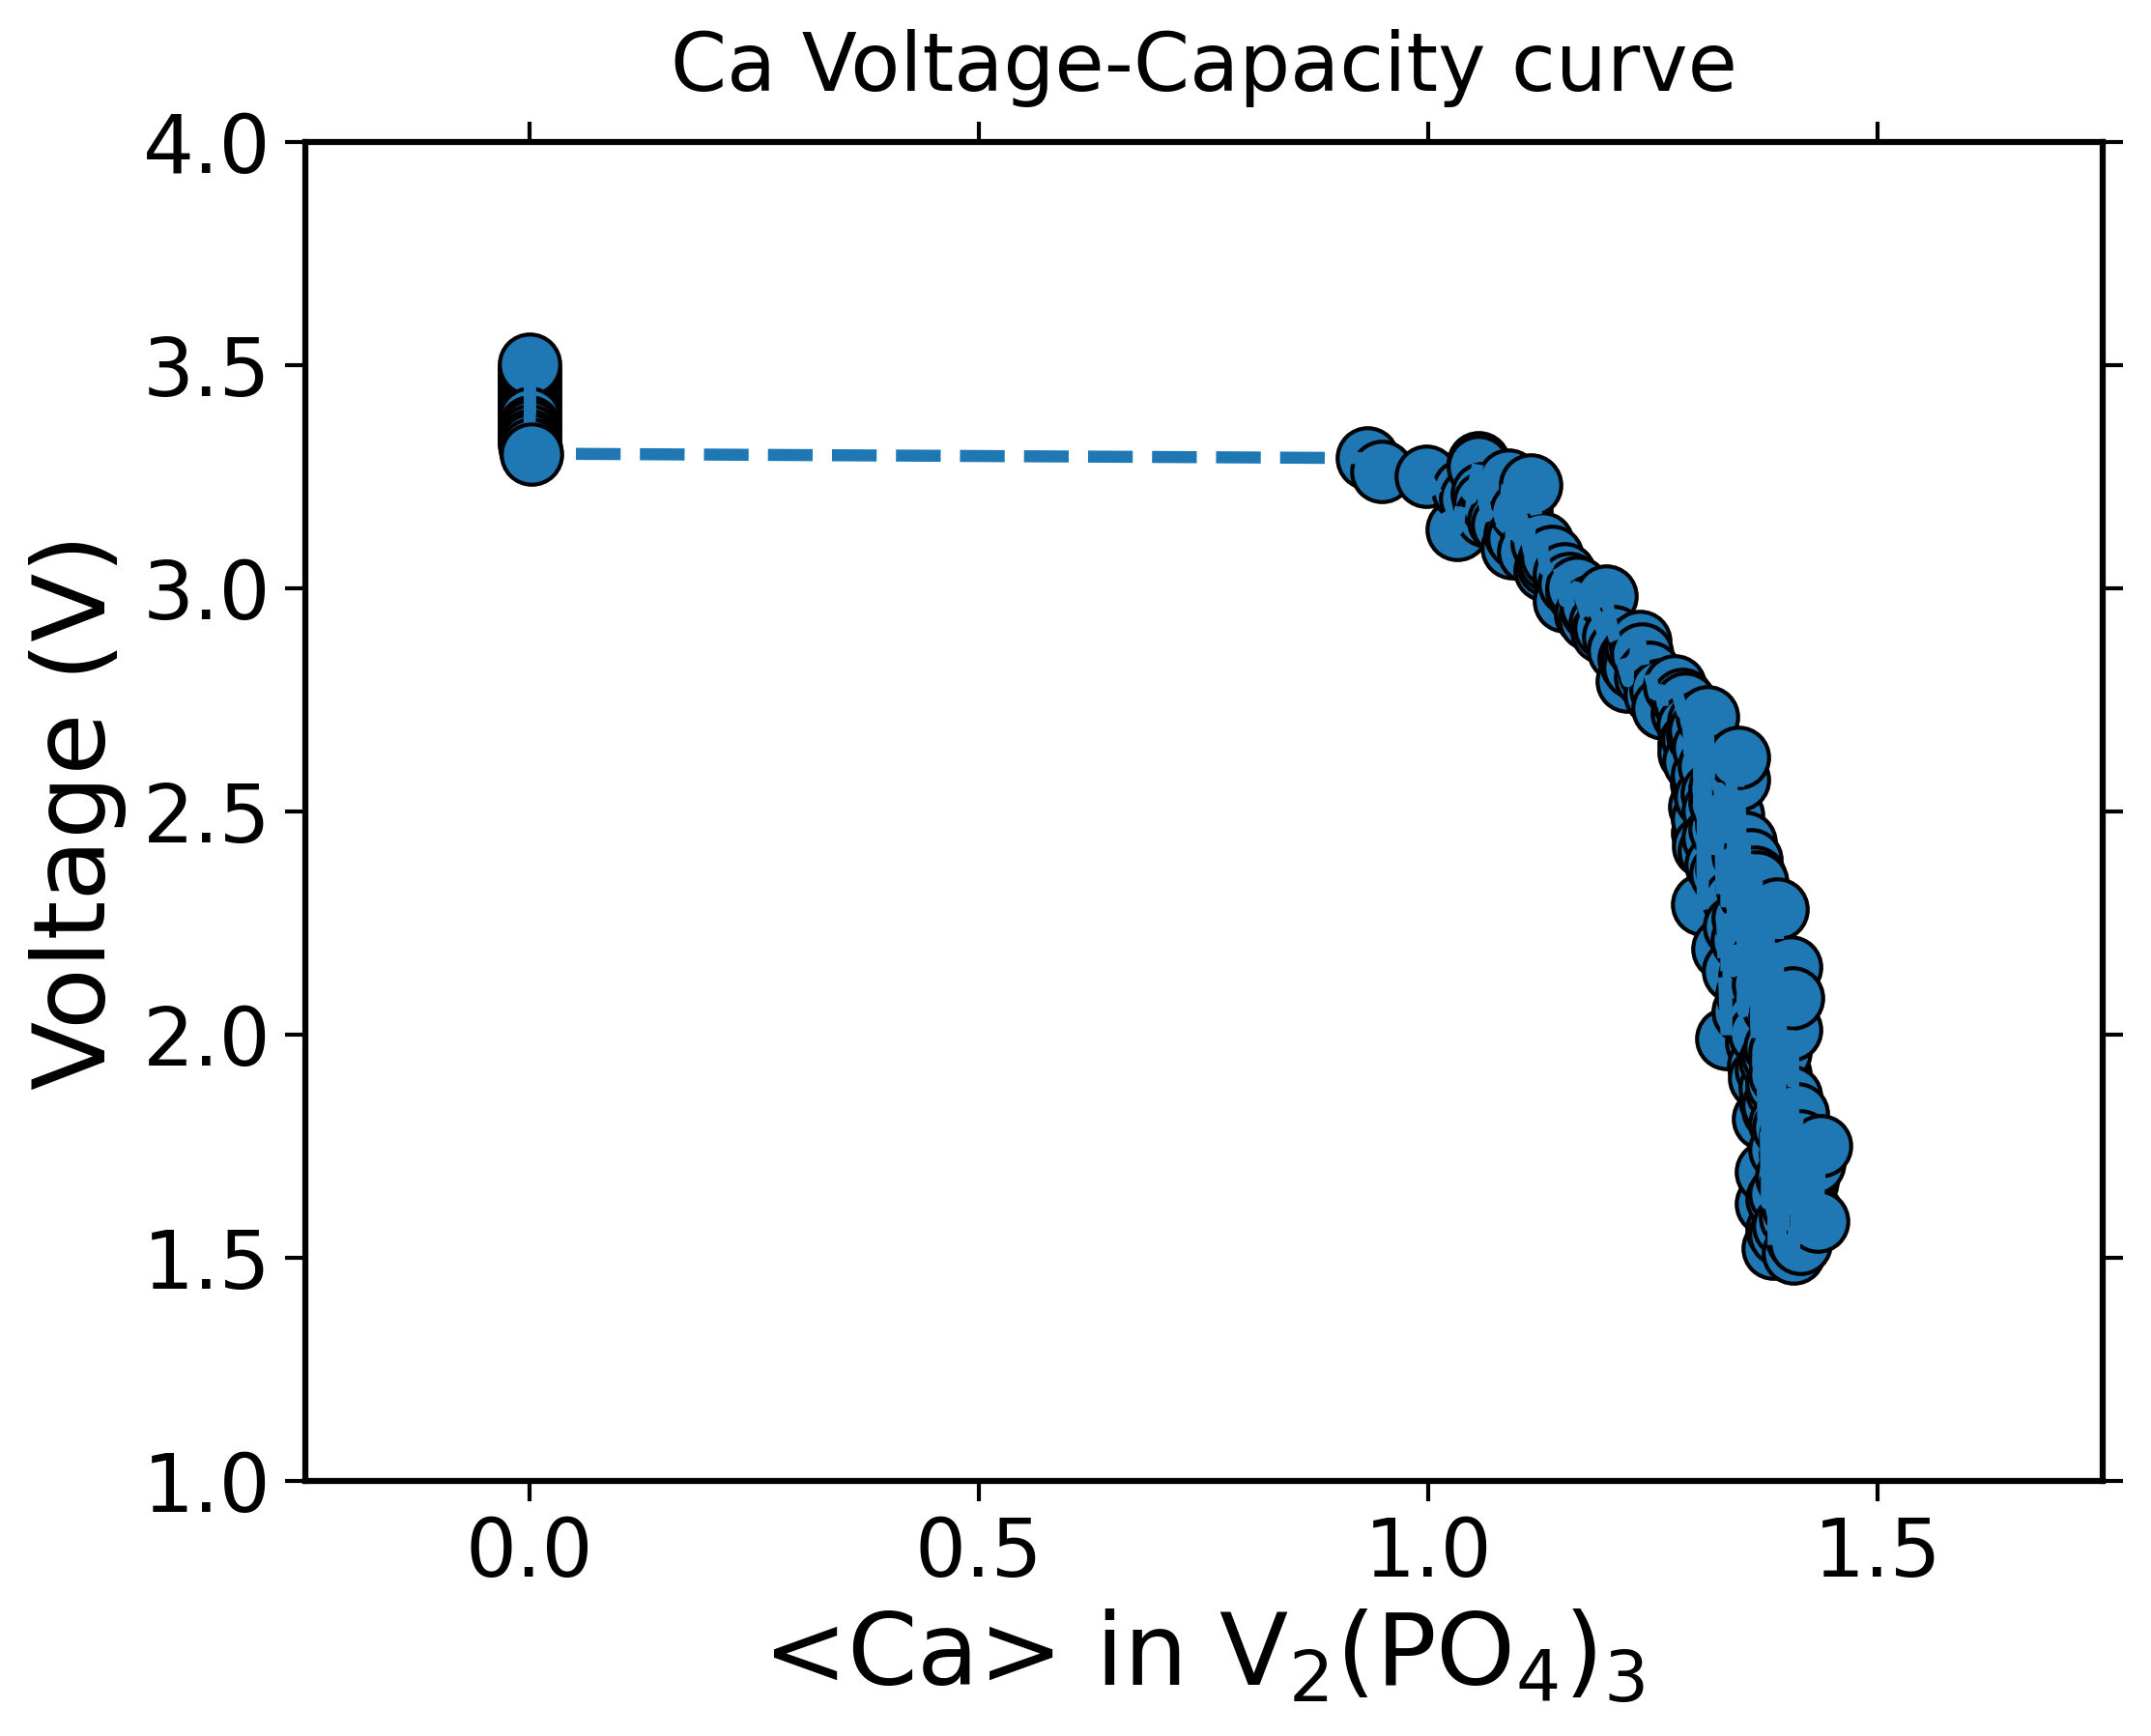

In [61]:
plt.scatter(re, sorted_chempos, color='tab:blue', edgecolors='black', linewidth=1)
plt.plot(re, sorted_chempos, linestyle='--', color='tab:blue')
plt.title("Ca Voltage-Capacity curve", fontsize=20, y=1.02)
plt.xlabel("<Ca> in $V_{2}(PO_{4})_{3}$")
plt.ylabel("Voltage (V)")
plt.ylim(1.0, 4.0)
plt.xlim(-0.25, 1.75)

In [34]:
# Get data from briefed saving
energy_list, occupancy_list, species_count_list = [], [], []
for i in saved_list:
    if 'occupancy.npz' in i:
        occupancy_list.append(i)
    elif 'energy.npy' in i:
        energy_list.append(i)
    elif 'species_count' in i:
        species_count_list.append(i)


In [23]:
def get_data_from_nps(saved_path, ca_chempo, na_chemp):
    """
    Under the save path, get the energy, occupancy, species_count data.
    All returns are list.
    Str, float, float
    """
    chempo_to_str = str(ca_chempo) + "_" + str(na_chempo)
    
    energy_path = os.path.join(saved_path, )
    return

In [23]:
energy_test_dir = '/global/scratch/users/yychoi94/CaNaVP_gcMC/300K_556_v_3_15/data/-6.15_-3.388_energy.npy'

In [24]:
energies = np.load(energy_test_dir)

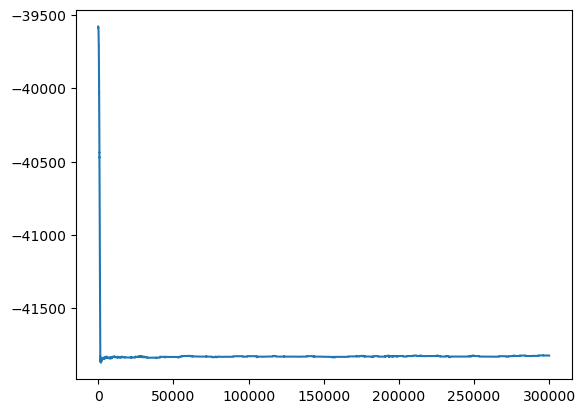

In [25]:
plt.plot(energies)

In [31]:
test_dir = '/global/scratch/users/yychoi94/CaNaVP_gcMC/300K_556_30_6020/data/-30.0_-3.64_species_count.json'
species_count = read_json(test_dir)
species_count = json.loads(species_count)

In [32]:
species_count['Ca2+'][-1]

0.0

In [33]:
species_count['Na+'][-1]

891.0

In [34]:
occu_dir = '/global/scratch/users/yychoi94/CaNaVP_gcMC/300K_556_30_6020/data/-30.0_-3.64_occupancy.npz'
occupancies = np.load(occu_dir)['o']

In [35]:
final_structure = ensemble.processor.structure_from_occupancy(occupancies[-1])

In [36]:
final_structure.to('POSCAR', './300_30_364_POSCAR')
np.save('./300_30_364_occu.npy', occupancies[-1])

In [47]:
occupancy_list[0]

'/global/scratch/users/yychoi94/CaNaVP_gcMC/5000K_556_7584_3544/data/-8.0_-4.3_occupancy.npz'

In [37]:
energies = np.load(energy_list[13])

In [48]:
occupancies = np.load(occupancy_list[0])['o']

In [91]:
species_count = read_json(species_count_list[0])
species_count = json.loads(species_count)

In [92]:
thin_trajectory = get_thin_trajectory(species_count, 100, 100)

In [ ]:
# Get data from hdf5
saved_sample = "/global/scratch/users/yychoi94/CaNaVP_gcMC/5000K_556_7584_3544/data/-8.3_-4.4_cn_sgmc.mson"
test = SampleContainer.from_hdf5(saved_sample)
occupancies = test.get_occupancies()
energies = test.get_energies()
species_count = test.get_species_counts()

In [50]:
get_sampling_efficiency(energies, 10000, 5)

(3110.3632522868074, 3106.425992911022, 0.20025349127162664)

In [60]:
na_occu = species_count[na] / tot_cation_site
ca_occu = species_count[ca] / tot_cation_site

In [72]:
na_ca_occu = []
for i, j in enumerate(na_occu):
    if i % 100 == 0:
        na_ca_occu.append((j, ca_occu[i]))

In [74]:
len(na_ca_occu)

5000

In [68]:
na_ca_occu[200]

(0.2125, 0.14083333333333334)

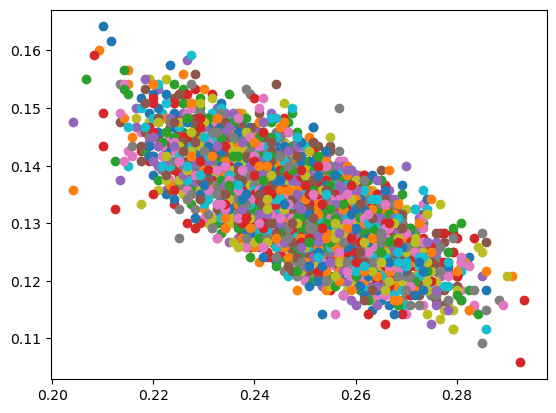

In [75]:
for i in na_ca_occu:
    plt.scatter(i[0], i[1])

In [52]:
species_count[ca] / 1200

array([0.12583, 0.12583, 0.12583, ..., 0.1375 , 0.1375 , 0.1375 ])

In [32]:
ensemble.processor.structure_from_occupancy(test.get_occupancies()[-1]).formula

'Na287 Ca165 V600 P900 O3600'

In [14]:
from glob import glob

save_dir = "/global/scratch/users/yychoi94/CaNaVP_gcMC/test"
saved_list = glob(save_dir + "/*")
# Currently have a problem on saving.
saved_list.remove("/global/scratch/users/yychoi94/CaNaVP_gcMC/data/-11.0_-2.0_cn_sgmc.mson")

In [10]:
saved_sample = "/global/scratch/users/yychoi94/CaNaVP_gcMC/test/-8.5_-4.2_cn_sgmc.mson"

In [35]:
saved_sample = "/global/scratch/users/yychoi94/CaNaVP_gcMC/CaNaVP_gcMC_300K_broad/data/-9.3_-4.65_cn_sgmc.mson"

In [12]:
test = SampleContainer.from_hdf5(saved_sample)

In [13]:
last = test.get_occupancies()[-1]

In [25]:
last_structure = ensemble.processor.structure_from_occupancy(last)

In [26]:
last_structure = last_structure.get_sorted_structure()

In [27]:
type(last_structure)

pymatgen.core.structure.Structure

In [28]:
last_structure.to("POSCAR", "./testPOSCAR")

In [38]:
ensemble.processor.compute_feature_vector(last) @ ensemble.processor.coefs

-15832.748286397347

In [47]:
v_sublattice = test.sublattices[3].active_sites

In [65]:
v_sublattice[0]

2280

In [50]:
test_occu = deepcopy(last)

In [72]:
for i, j in enumerate(test_occu[v_sublattice]):
    rd = random.uniform(0, 1)
    if rd < 1/3:
        test_occu[v_sublattice[0] + i] = 0
    elif rd < 2/3:
        test_occu[v_sublattice[0] + i] = 1
    else:
        test_occu[v_sublattice[0] + i] = 2

In [73]:
test_occu[v_sublattice]

array([2, 1, 0, 0, 0, 1, 0, 2, 1, 1, 2, 2, 0, 1, 0, 0, 1, 2, 1, 0, 0, 0,
       2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 2, 0, 2, 1, 1, 2, 0, 0, 2, 1, 1, 2, 0, 1, 0, 0, 1, 2,
       2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 1, 2, 2, 0, 2, 0, 2, 1, 2, 0, 2,
       0, 2, 1, 0, 1, 2, 1, 1, 0, 2, 2, 2, 2, 1, 1, 1, 0, 2, 2, 1, 0, 0,
       2, 1, 2, 0, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 2, 0, 1, 1, 1, 0, 0, 2,
       2, 1, 2, 1, 0, 0, 2, 1, 2, 0, 1, 1, 1, 2, 2, 0, 2, 0, 0, 0, 1, 2,
       2, 0, 0, 0, 0, 2, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 2, 2, 2, 1, 1, 2, 2, 0, 1,
       2, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1])

In [74]:
ensemble.processor.compute_feature_vector(test_occu) @ ensemble.processor.coefs

-15723.577343982271

In [75]:
random_energy_list = []

In [78]:
for _ in np.arange(100):
    print("{} iteration".format(_))
    test_occu = deepcopy(last)
    for i, j in enumerate(test_occu[v_sublattice]):
        rd = random.uniform(0, 1)
        if rd < 1/3:
            test_occu[v_sublattice[0] + i] = 0
        elif rd < 2/3:
            test_occu[v_sublattice[0] + i] = 1
        else:
            test_occu[v_sublattice[0] + i] = 2
    random_energy_list.append(ensemble.processor.compute_feature_vector(test_occu) @ ensemble.processor.coefs)

0 iteration
1 iteration
2 iteration
3 iteration
4 iteration
5 iteration
6 iteration
7 iteration
8 iteration
9 iteration
10 iteration
11 iteration
12 iteration
13 iteration
14 iteration
15 iteration
16 iteration
17 iteration
18 iteration
19 iteration
20 iteration
21 iteration
22 iteration
23 iteration
24 iteration
25 iteration
26 iteration
27 iteration
28 iteration
29 iteration
30 iteration
31 iteration
32 iteration
33 iteration
34 iteration
35 iteration
36 iteration
37 iteration
38 iteration
39 iteration
40 iteration
41 iteration
42 iteration
43 iteration
44 iteration
45 iteration
46 iteration
47 iteration
48 iteration
49 iteration
50 iteration
51 iteration
52 iteration
53 iteration
54 iteration
55 iteration
56 iteration
57 iteration
58 iteration
59 iteration
60 iteration
61 iteration
62 iteration
63 iteration
64 iteration
65 iteration
66 iteration
67 iteration
68 iteration
69 iteration
70 iteration
71 iteration
72 iteration
73 iteration
74 iteration
75 iteration
76 iteration
77 iterat

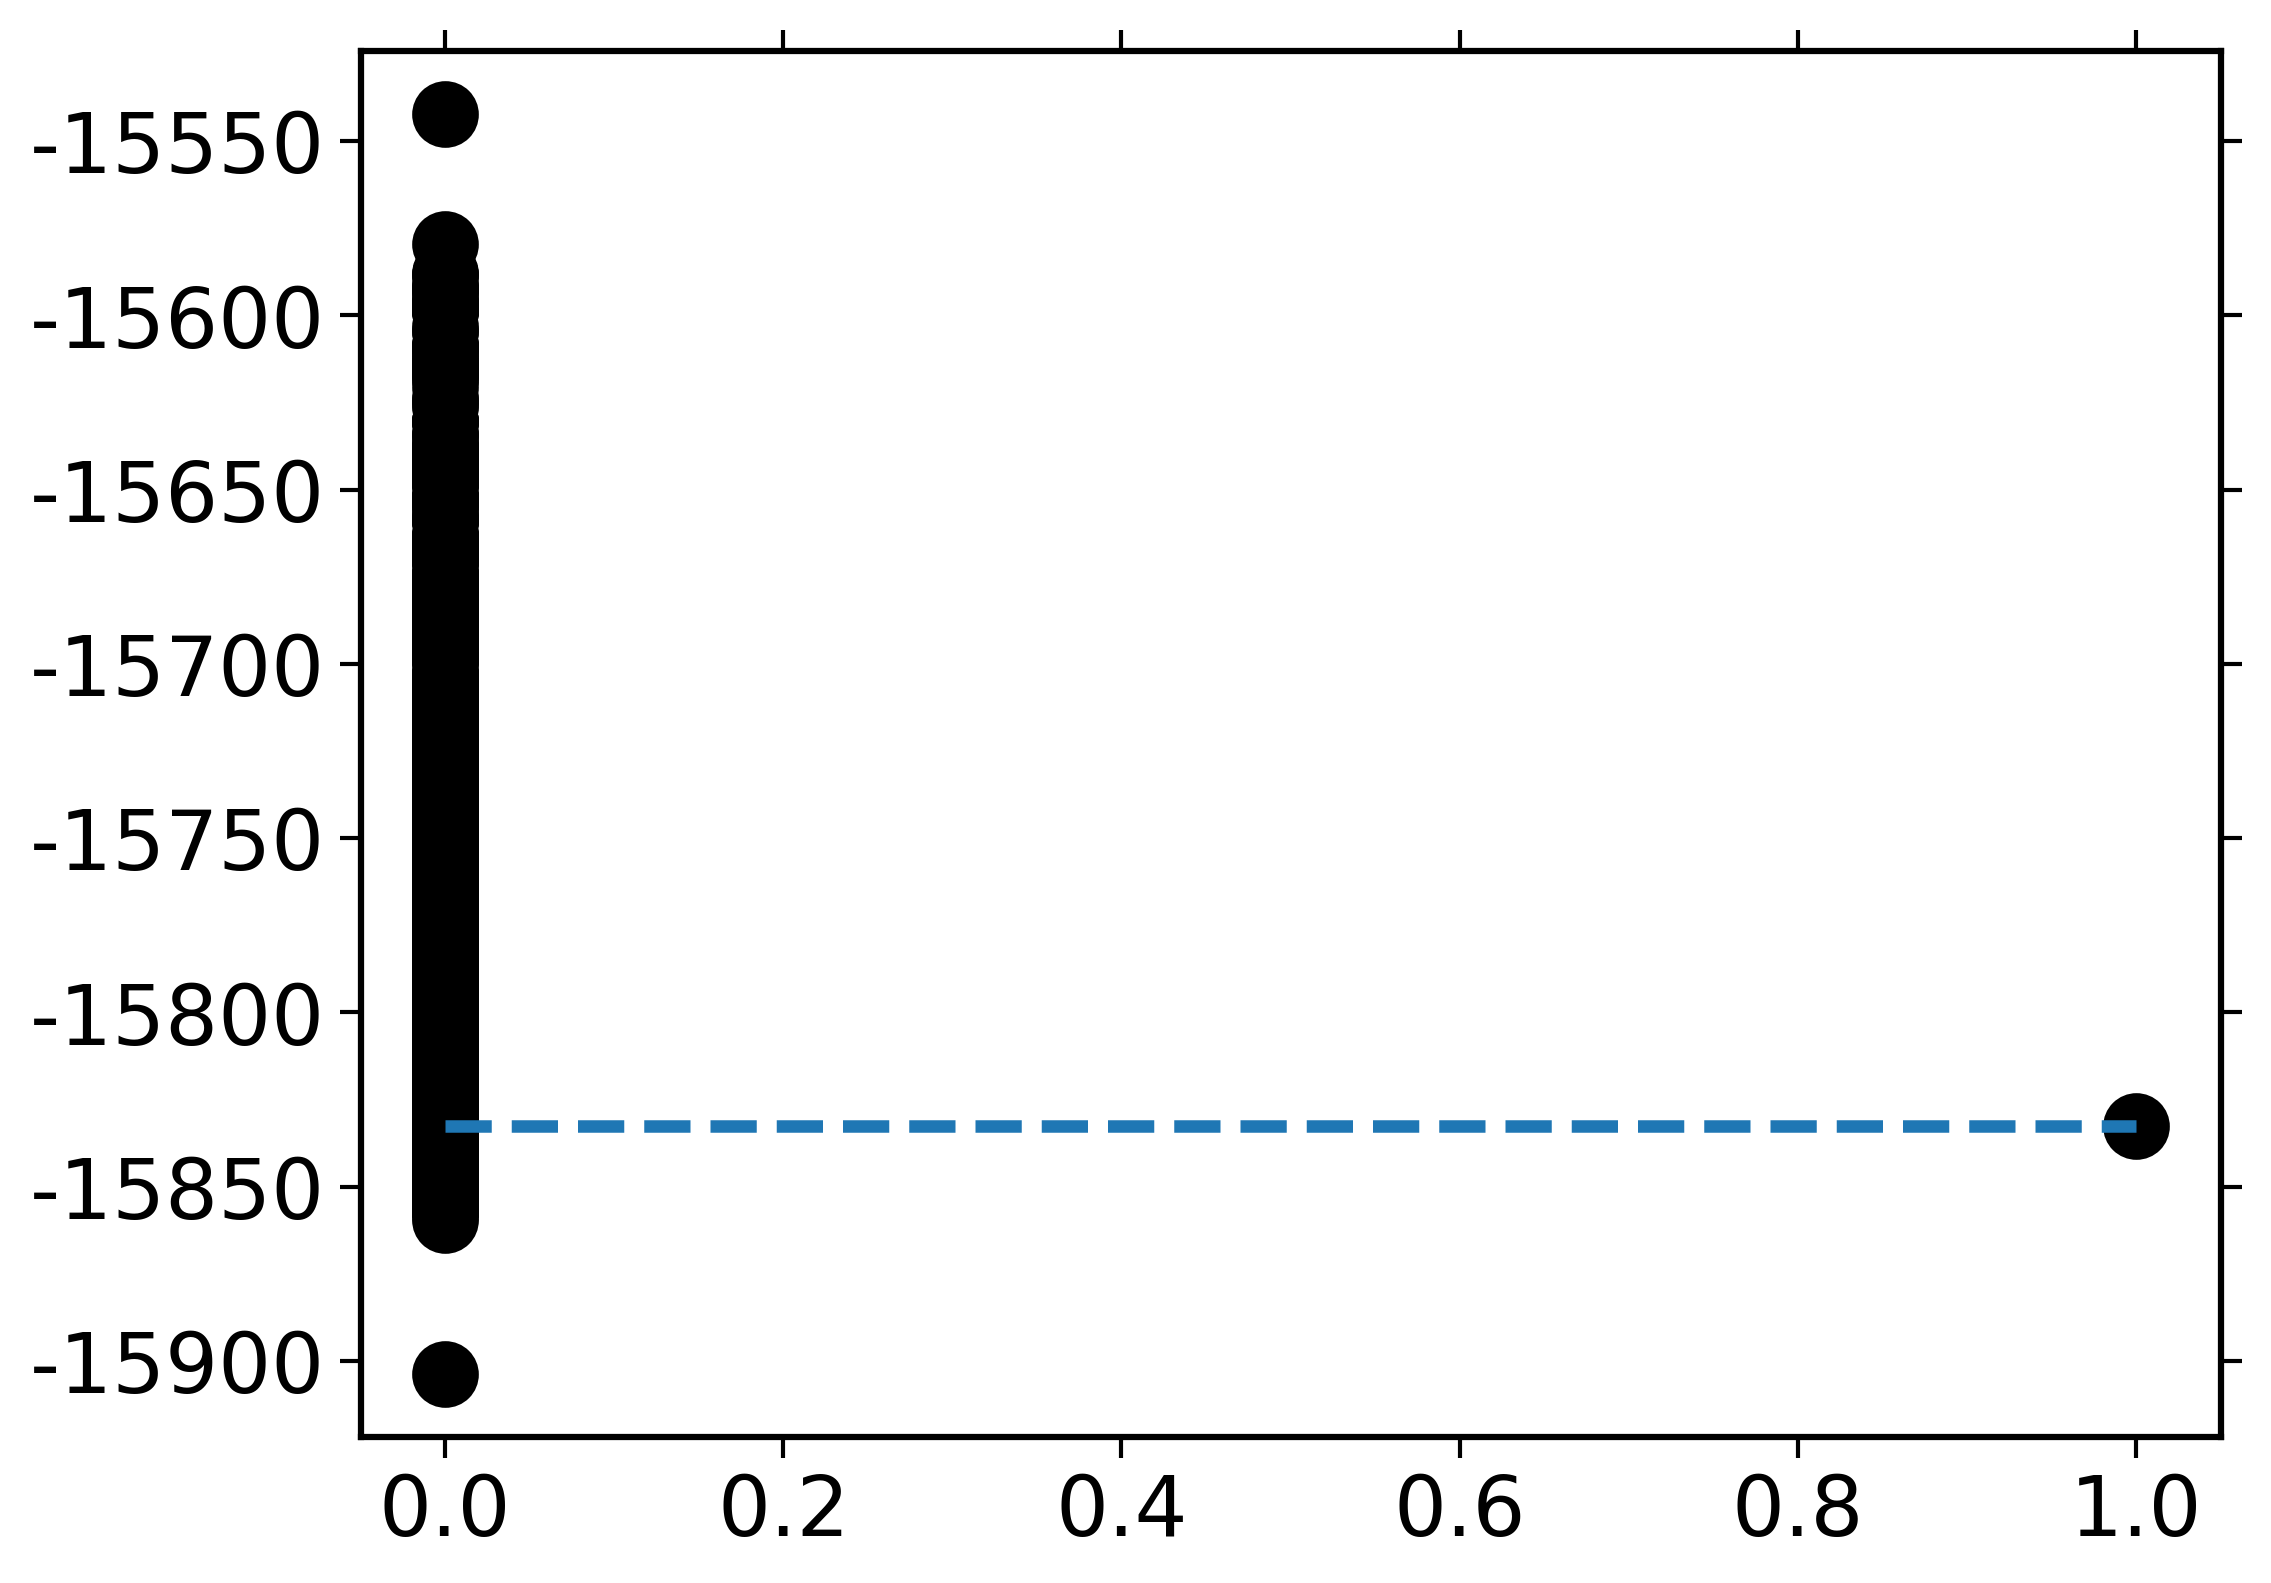

In [92]:
for i in random_energy_list:
    plt.scatter(0, i, color='k')
plt.scatter(1, -15832.748286397347, color='k')
plt.hlines(y =-15832.748286397347, xmin=0, xmax=1, linestyle='--')

In [39]:
test.get_occupancies()[-1]

array([0, 0, 0, ..., 1, 1, 1])

In [165]:
species_count = test.get_species_counts()

In [166]:
species_count

defaultdict(<function smol.moca.sampler.container.SampleContainer.get_species_counts.<locals>.<lambda>()>,
            {Species Na+: array([110., 110., 110., ..., 216., 216., 216.]),
             Species Ca2+: array([66., 66., 66., ...,  0.,  0.,  0.]),
             Vacancy vacA0+: array([304., 304., 304., ..., 264., 264., 264.]),
             Species P5+: array([360., 360., 360., ..., 360., 360., 360.]),
             Species O2-: array([1440., 1440., 1440., ..., 1440., 1440., 1440.]),
             Species V3+: array([136., 136., 136., ...,  96.,  96.,  96.]),
             Species V4+: array([ 90.,  90.,  90., ..., 144., 144., 144.]),
             Species V5+: array([14., 14., 14., ...,  0.,  0.,  0.])})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


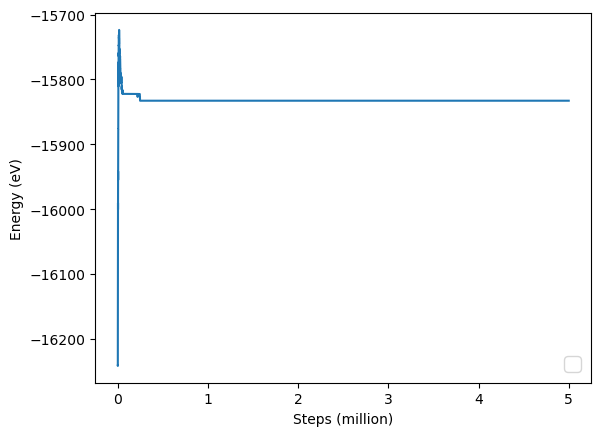

In [40]:
from matplotlib import pyplot as plt

energies = test.get_energies()
plt.plot(np.arange(len(energies)) / 100000, energies)
plt.ylabel("Energy (eV)")
plt.xlabel("Steps (million)")
plt.legend(fontsize=15, loc='lower right')

In [161]:
def get_V_ratio(species_count):

    plt.plot(np.arange(len(species_count[na])) / 100000, species_count[na] / 480, label='Na+')
    plt.plot(np.arange(len(species_count[na])) / 100000, species_count[ca] / 480, label='Ca2+')
    plt.plot(np.arange(len(species_count[na])) / 100000, species_count[v3] / 240, label='V3+')
    plt.plot(np.arange(len(species_count[na])) / 100000, species_count[v4] / 240, label='V4+')
    plt.plot(np.arange(len(species_count[na])) / 100000, species_count[v5] / 240, label='V5+')
    plt.ylabel("Ratio")
    plt.xlabel("Steps (million)")
    plt.legend(fontsize=15, loc='right')
    
    return

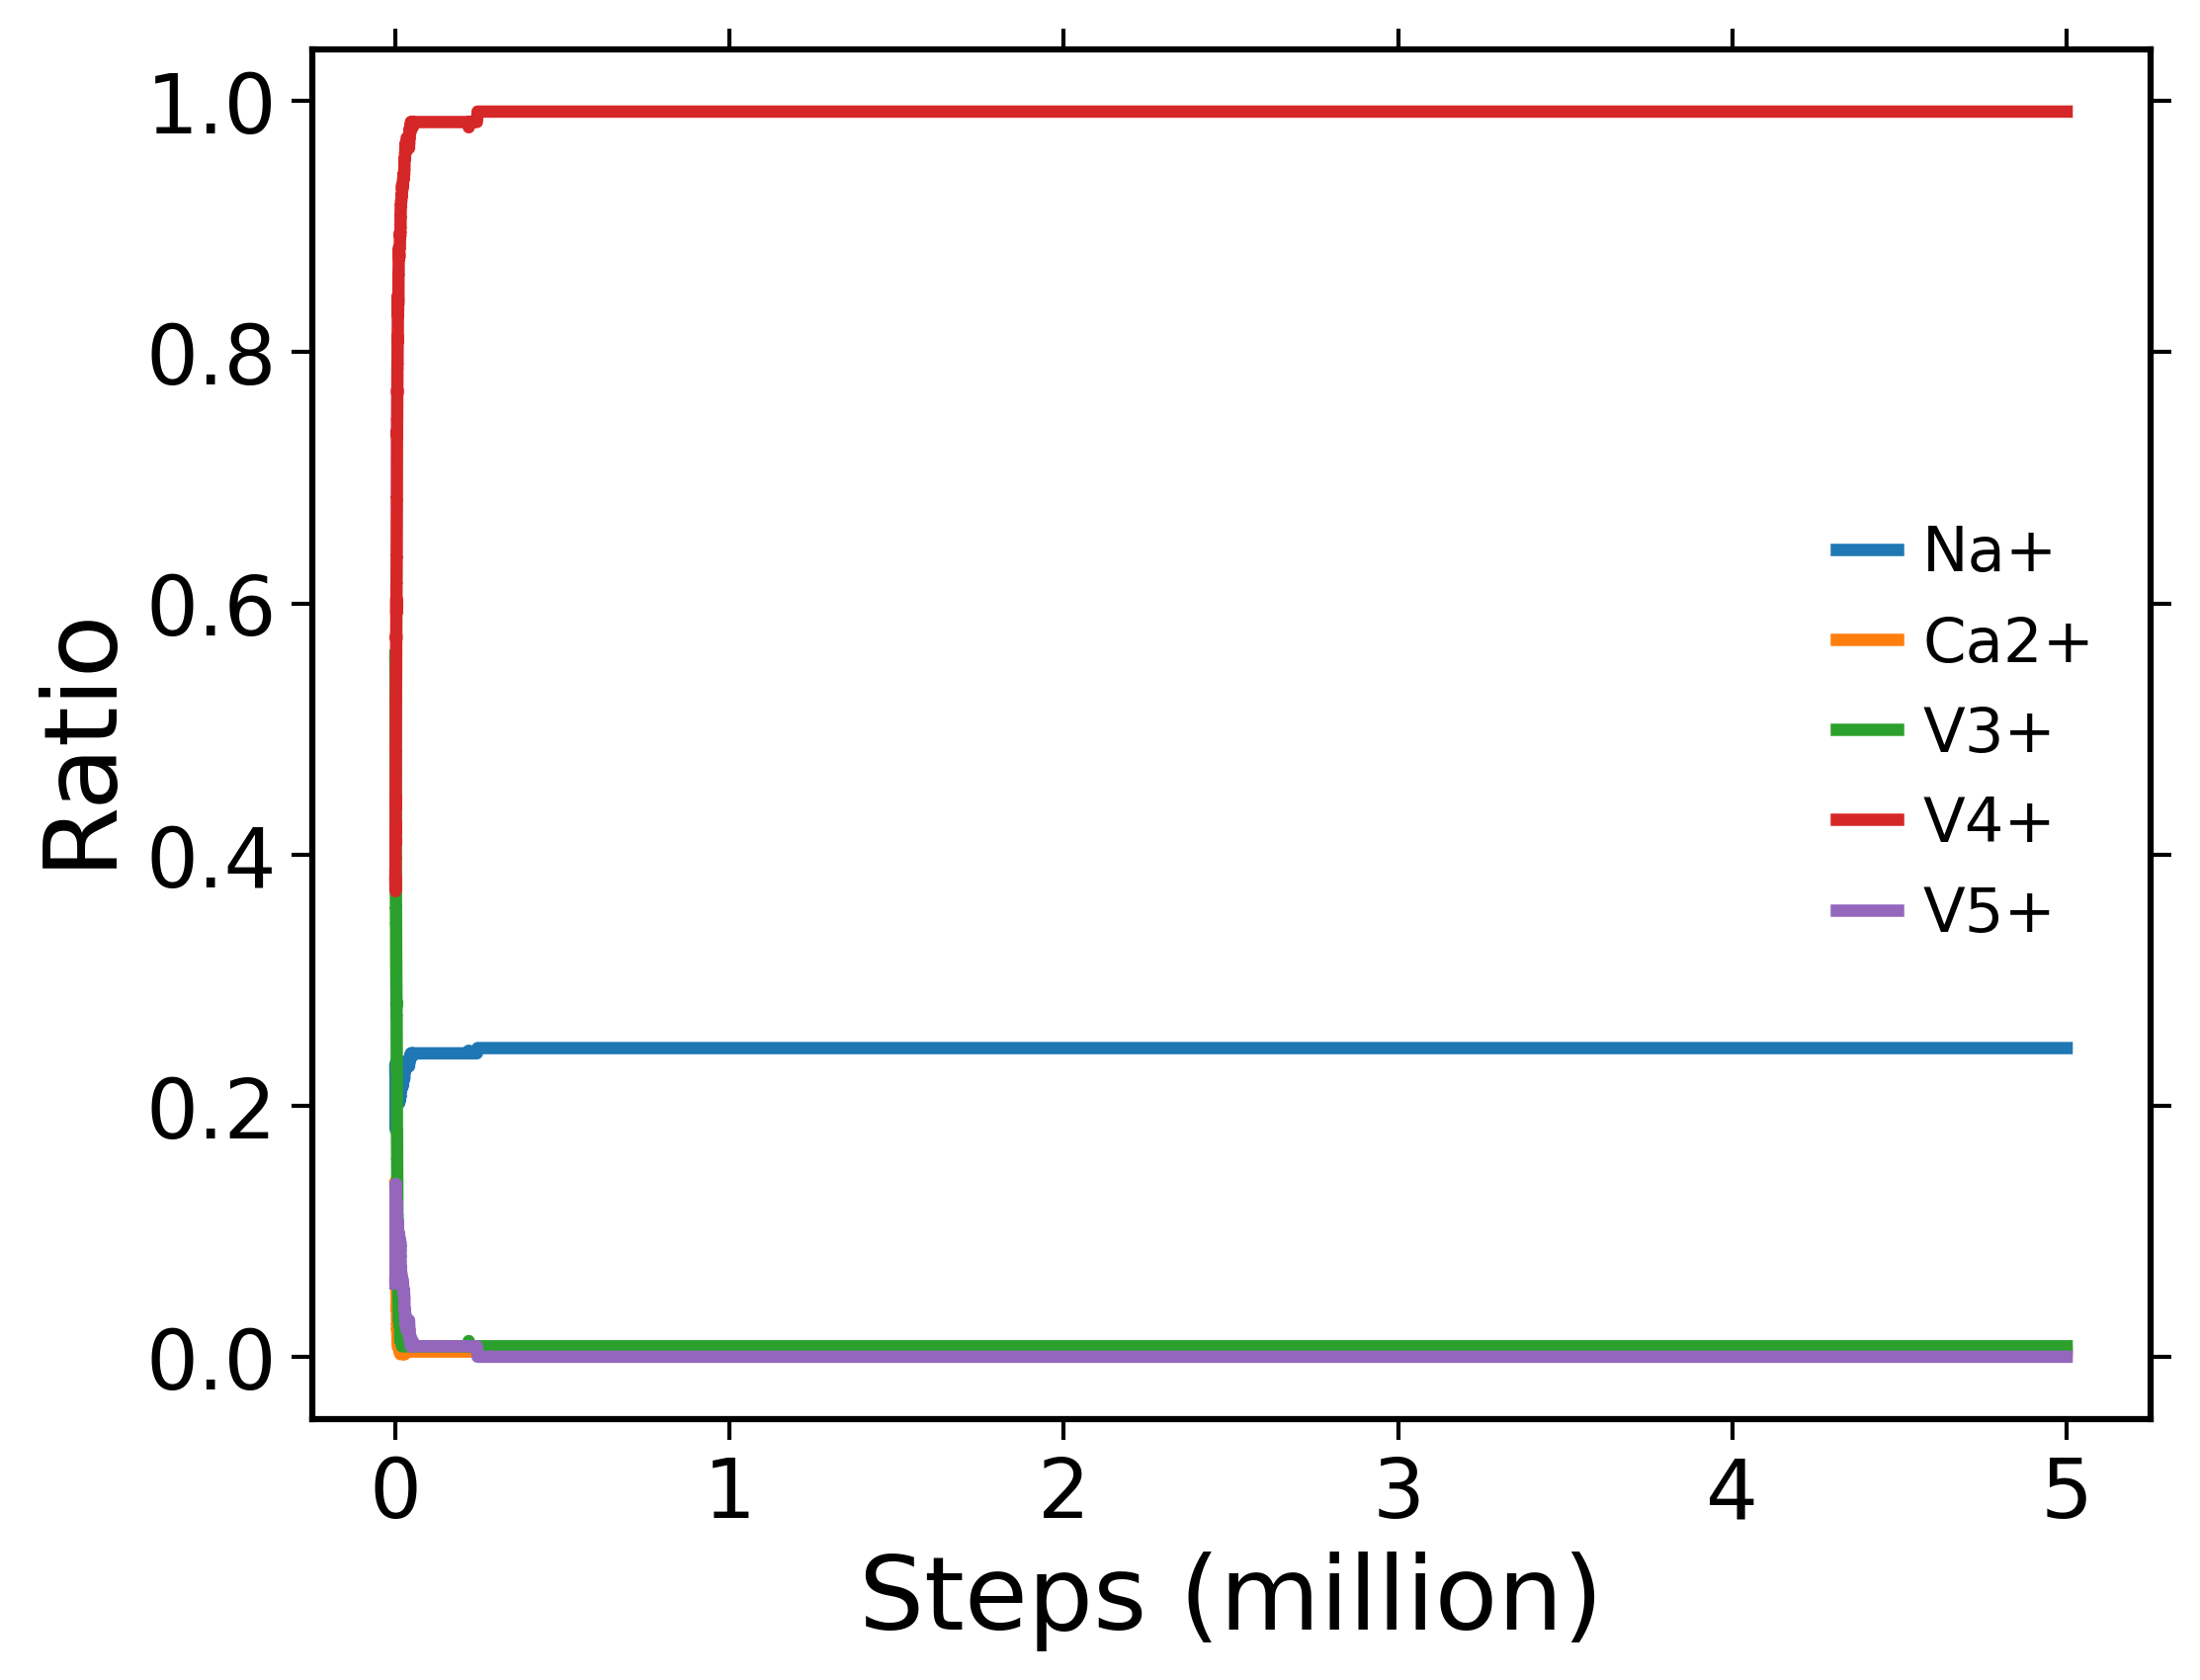

In [162]:
get_V_ratio(species_count)

In [84]:
for i, j in enumerate(energy_set):
    if (np.var(energy_set[i:i+1000])) < 0.1:
        stop_i = i
        break

In [85]:
stop_i

5845

In [90]:
energy_set[:stop_i]

array([-16056.98178, -16063.73026, -16061.35775, ..., -16834.70229,
       -16834.70229, -16834.70229])

In [33]:
energy_set[400000]

-16851.336398789925

In [19]:
enthalpy_set = test.get_enthalpies()

In [20]:
occupancy_set = test.get_occupancies()

In [21]:
species_count = test.get_species_counts()

In [88]:
species_count[na][:stop_i]

array([ 64.,  66.,  74., ..., 360., 360., 360.])

In [89]:
species_count[ca][-1]

0.0

In [23]:
# Atoms.
na = Species('Na', 1)
ca = Species('Ca', 2)
v3 = Species('V', 3)
v4 = Species('V', 4)
v5 = Species('V', 5)
vac = Vacancy()

In [10]:
ensemble.processor.structure_from_occupancy(test.get_occupancies()[0])

NameError: name 'ensemble' is not defined

In [35]:
ensemble.chemical_potentials

ChemPots: {Species Na+: -6.5, Species Ca2+: -8, Vacancy vacA0+: 0, Species V3+: 0, Species V4+: 0, Species V5+: 0}

In [37]:
sampler = Sampler.from_ensemble(ensemble, step_type="tableflip",
                                    temperature=300, optimize_basis=True)

/global/home/users/yychoi94/codes/smol/smol/moca/comp_space.py:372: UserWarning: Basis optimization can be very costly at your composition space size = 4718592. Do this at your own risk!
  warnings.warn("Basis optimization can be very costly "
/global/home/users/yychoi94/codes/smol/smol/moca/sampler/mcusher.py:358: UserWarning: Current occupancy violates compspace constraints! Are you initializing trace?
  warnings.warn("Current occupancy violates compspace constraints! "


In [38]:
sampler.samples.metadata

{'kernel': 'Metropolis',
 'step': 'tableflip',
 'chemical_potentials': {Species Na+: -6.5,
  Species Ca2+: -8,
  Vacancy vacA0+: 0,
  Species V3+: 0,
  Species V4+: 0,
  Species V5+: 0},
 'seeds': [17155081175886979374447532922693912617]}

In [38]:
"/global/scratch/users/yychoi94/CaNaVP_gcMC/data/-11.0_-2.0_cn_sgmc.mson".split('/')[-1].split('_')[:2]

['-11.0', '-2.0']

In [12]:
import matplotlib as mpl
def set_rc_params():
    """
    General params for plot.
    """
    params = {'axes.linewidth': 1.5,
              'axes.unicode_minus': False,
              'figure.dpi': 300,
              'font.size': 25,
              'legend.frameon': False,
              'legend.handletextpad': 0.4,
              'legend.handlelength': 1,
              'legend.fontsize': 10,
              'lines.markeredgewidth': 4,
              'lines.linewidth': 3,
              'lines.markersize': 15,
              'mathtext.default': 'regular',
              'savefig.bbox': 'tight',
              'xtick.labelsize': 20,
              'ytick.labelsize': 20,
              'xtick.major.size': 5,
              'xtick.minor.size': 3,
              'ytick.major.size': 5,
              'ytick.minor.size': 3,
              'xtick.major.width': 1,
              'xtick.minor.width': 0.5,
              'ytick.major.width': 1,
              'ytick.minor.width': 0.5,
              'xtick.top': True,
              'ytick.right': True,
              'axes.edgecolor': 'black',
              'legend.fancybox': True,
              'figure.figsize': [8, 6]}
    for p in params:
        mpl.rcParams[p] = params[p]

In [13]:
set_rc_params()